In [ ]:
import math
import torch
import time
import random
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.parameter import Parameter
from torch.nn import init
from torch import Tensor
from scipy.special import gamma 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb}'
custom_params = {
    # Font and text settings
    'font.size': 8,                
    'axes.labelsize': 8,           
    'axes.titlesize': 8,           
    'xtick.labelsize': 8,          
    'ytick.labelsize': 8,          
    'legend.fontsize': 6,          
    
    # Line properties
    'lines.linewidth': 1.2,        
    'lines.markersize': 4,         
    
    # Figure dimensions and quality
    'figure.figsize': (3.5, 2.5),  
    
    # Axis properties
    'axes.linewidth': 0.8,         
    'grid.linewidth': 0.5,         
    'grid.alpha': 0.3,             
}

# Apply the customized parameters to matplotlib
plt.rcParams.update(custom_params)


def MSE(pred,true):
    return np.mean((pred-true)**2)

def MAE(pred, true):
    return np.mean(np.abs(pred-true))

def RMSE(pred,true):
    return np.sqrt(np.mean((pred-true)**2))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def clip_matrix_norm(matrix, max_norm):
    norm = torch.norm(matrix)
    if norm > max_norm:
        matrix = matrix * (max_norm / norm)
    return matrix


class Fractional_Order_Matrix_Differential_Solver(torch.autograd.Function):
    @staticmethod
    def forward(ctx,input1,w,b,alpha,c):
        alpha = torch.tensor(alpha)
        c = torch.tensor(c)
        ctx.save_for_backward(input1,w,b,alpha,c)
        outputs = input1@w + b
        return outputs

    @staticmethod
    def backward(ctx, grad_outputs):
        input1,w,b,alpha,c = ctx.saved_tensors
        x_fractional, w_fractional = Fractional_Order_Matrix_Differential_Solver.Fractional_Order_Matrix_Differential_Linear(input1,w,b,alpha,c)   
        x_grad = grad_outputs@x_fractional
        w_grad = w_fractional@grad_outputs
        b_grad = grad_outputs.sum(dim=0)
        return x_grad, w_grad, b_grad,None,None
          
    @staticmethod
    def Fractional_Order_Matrix_Differential_Linear(xs,ws,b,alpha,c):
        wf = ws[:,0].view(1,-1)
        #main
        w_main = torch.mul(xs,(torch.abs(wf)+1e-8)**(1-alpha)/gamma(2-alpha))
        #partial
        w_partial = torch.mul((xs@wf.T).expand(xs.shape) - torch.mul(xs,wf) + b[0], torch.sgn(wf)*(torch.abs(wf)+1e-8)**(-alpha)/gamma(1-alpha))
        return ws.T, (w_main + clip_matrix_norm(w_partial,c)).transpose(-2,-1)

class FLinear(nn.Module):
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, alpha=0.9, c=1.0, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.c = c
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        return Fractional_Order_Matrix_Differential_Solver.apply(x, self.weight.T, self.bias, self.alpha,self.c)

    def extra_repr(self) -> str:
        return f"in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}"

In [62]:
# Configuration parameters
slide_windows_size = 192  # Input sequence length
pred_length = 384        # Prediction horizon length
stock = 'ETTh1'            # Dataset name (ETTm2 for comparison)
features_j = 6           # Target feature index (DJI:4, ETTm2:6)
num_feature = features_j + 1         #(DJI:5, ETTm2:7)

# Load data
root = r'C:\Users\Administrator\torch_zxj\博士第四篇代码'
df_DJIA = pd.read_csv(root+'/data/'+stock+'.csv')
# df_DJIA = pd.read_csv(r'./data/'+stock+'.csv')
del df_DJIA['date']  # Remove date column

# 1. Split data first (7:1:2 ratio)
def split_time_series(data, train_ratio=0.7, val_ratio=0.1):
    """
    Split time series data in chronological order
    
    Args:
        data: Complete time series data
        train_ratio: Proportion for training set
        val_ratio: Proportion for validation set
    
    Returns:
        train_data, val_data, test_data: Split datasets
    """
    n_samples = len(data)
    train_end = int(n_samples * train_ratio)
    val_end = train_end + int(n_samples * val_ratio)
    
    # Split in chronological order (important for time series)
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    
    return train_data, val_data, test_data

# Split raw data first
train_raw, val_raw, test_raw = split_time_series(df_DJIA.values, 0.7, 0.1)

print(f"Data split results:")
print(f"  Training set: {len(train_raw)} samples ({len(train_raw)/len(df_DJIA)*100:.1f}%)")
print(f"  Validation set: {len(val_raw)} samples ({len(val_raw)/len(df_DJIA)*100:.1f}%)")
print(f"  Test set: {len(test_raw)} samples ({len(test_raw)/len(df_DJIA)*100:.1f}%)")

# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(train_raw)

# Transform all datasets using training set statistics
train_scaled = scaler.transform(train_raw)
val_scaled = scaler.transform(val_raw)  # Use training set statistics
test_scaled = scaler.transform(test_raw)  # Use training set statistics

# 3. Create sequences for time series forecasting
def create_sequences(data, slide_windows_size, pred_length, target_idx):
    """
    Create input-output sequences for time series forecasting
    
    Args:
        data: Multivariate time series data
        slide_windows_size: Input sequence length (look-back window)
        pred_length: Output sequence length (forecast horizon)
        target_idx: Index of target feature to predict
    
    Returns:
        X: Input sequences [samples, seq_len, features]
        y: Target sequences [samples, pred_length]
    """
    X, y = [], []
    for i in range(len(data) - slide_windows_size - pred_length + 1):
        # Input sequence: sliding window of features
        X.append(data[i:i+slide_windows_size, :])  # [seq_len, features]
        # Target sequence: future values of target feature
        y.append(data[i+slide_windows_size:i+slide_windows_size+pred_length, target_idx])  
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Create sequences for each dataset
X_train, y_train = create_sequences(train_scaled, slide_windows_size, pred_length, features_j)
X_val, y_val = create_sequences(val_scaled, slide_windows_size, pred_length, features_j)
X_test, y_test = create_sequences(test_scaled, slide_windows_size, pred_length, features_j)

print(f"\nSequence creation results:")
print(f"  Training set: X{X_train.shape}, y{y_train.shape}")
print(f"  Validation set: X{X_val.shape}, y{y_val.shape}")
print(f"  Test set: X{X_test.shape}, y{y_test.shape}")

# 4. Convert to PyTorch tensors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print(f"\nTensor shapes:")
print(f"  X_train_tensor: {X_train_tensor.shape}")
print(f"  y_train_tensor: {y_train_tensor.shape}")
print(f"  X_val_tensor: {X_val_tensor.shape}")
print(f"  y_val_tensor: {y_val_tensor.shape}")
print(f"  X_test_tensor: {X_test_tensor.shape}")
print(f"  y_test_tensor: {y_test_tensor.shape}")

Data split results:
  Training set: 12194 samples (70.0%)
  Validation set: 1742 samples (10.0%)
  Test set: 3484 samples (20.0%)

Sequence creation results:
  Training set: X(11619, 192, 7), y(11619, 384)
  Validation set: X(1167, 192, 7), y(1167, 384)
  Test set: X(2909, 192, 7), y(2909, 384)

Using device: cuda:0

Tensor shapes:
  X_train_tensor: torch.Size([11619, 192, 7])
  y_train_tensor: torch.Size([11619, 384])
  X_val_tensor: torch.Size([1167, 192, 7])
  y_val_tensor: torch.Size([1167, 384])
  X_test_tensor: torch.Size([2909, 192, 7])
  y_test_tensor: torch.Size([2909, 384])


In [63]:
batch_size = 256
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [54]:
alphas = [1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]   
cs = [5.0,1.0,0.1]
lrs =[0.3,0.1,0.03,0.01,0.003,0.001]                 

# root = r'C:\Users\Administrator\torch_zxj\博士第四篇代码'
# batch_size = 256
num_epochs = 200
set_seed()
# train_data = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=512, hidden_size2=256,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear(input_size, hidden_size1, alpha,c)    
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear(hidden_size1, hidden_size2, alpha,c) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear(hidden_size2, output_size, alpha,c)  
        
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x

for alpha in alphas:
    # best_evaluation = 1000
    for c in cs:
        for lr in lrs:
            
            print('')
            print('alpha:',alpha)
            print('c:',c)
            print('lr:',lr)
            set_seed()
            model = MLP(input_size=slide_windows_size*num_feature).to(device)
            best_loss = 1000
            criterion = nn.MSELoss()
            # optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-2)
            optimizer = torch.optim.SGD(model.parameters(),lr=lr)
            for ii in range(num_epochs):
                model.train()
                loss_sum = 0
                for inputs, targets in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss_sum += loss
                    loss.backward()   #The default value of retain_graph is False.
                    optimizer.step()
                    
                model.eval()
                with torch.no_grad():
                    Val_outputs = model(X_val_tensor)
                    RMSE_val = RMSE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
                    MAE_val = MAE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
                    MAPE_val = MAPE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
                    best_val = RMSE_val + MAE_val+MAPE_val

                    if best_loss > best_val:
                        best_loss = best_val
                        torch.save(model.state_dict(), root+'/model/SGD/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth') 
                        # torch.save(model.state_dict(), r'./model/SGD/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth') 

            # model.load_state_dict(torch.load('./model/SGD/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth'))
            model.load_state_dict(torch.load(root+'/model/SGD/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth'))
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test_tensor)
            RMSE_test = RMSE(y_test_tensor.cpu().numpy(),test_outputs.cpu().detach().numpy())
            MAE_test = MAE(y_test_tensor.cpu().numpy(),test_outputs.cpu().detach().numpy())
            MAPE_test = MAPE(y_test_tensor.cpu().numpy(),test_outputs.cpu().detach().numpy())
            print(str(alpha)+'_'+str(lr)+'_'+f'RMSE:{RMSE_test:.4f}')
            print(str(alpha)+'_'+str(lr)+'_'+f'MAE:{MAE_test:.4f}')
            print(str(alpha)+'_'+str(lr)+'_'+f'MAPE:{MAPE_test:.4f}')
            print('RMSE_test+MAE_test+MAPE_test:',RMSE_test+MAE_test+MAPE_test)
            # if best_evaluation > RMSE_test + MAE_test + MAPE_test:
            #     best_evaluation = RMSE_test + MAE_test + MAPE_test
            #     print('best_evaluation:',best_evaluation)


alpha: 1.0
c: 5.0
lr: 0.3


KeyboardInterrupt: 

In [50]:
alphas = [1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]   
c = 1.0  #DJI  0.1 ETTh1  1.0
lr = 0.03   #DJI  0.1  ETTh1  0.03        

# root = r'C:\Users\Administrator\torch_zxj\博士第四篇代码'
# batch_size = 256
num_epochs = 200
set_seed()
# train_data = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=512, hidden_size2=256,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear(input_size, hidden_size1, alpha,c)    
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear(hidden_size1, hidden_size2, alpha,c) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear(hidden_size2, output_size, alpha,c)  
        
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x

RMSE_s = []
MAE_s = []
MAPE_s = []
total_s = []
for alpha in alphas:
    set_seed()
    model = MLP(input_size=slide_windows_size*num_feature).to(device)
    best_loss = 1000
    criterion = nn.MSELoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-2)
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
    for ii in range(num_epochs):
        model.train()
        loss_sum = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss_sum += loss
            loss.backward()   #The default value of retain_graph is False.
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            Val_outputs = model(X_val_tensor)
            RMSE_val = RMSE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
            MAE_val = MAE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
            MAPE_val = MAPE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
            best_val = RMSE_val + MAE_val+MAPE_val

            if best_loss > best_val:
                best_loss = best_val
                torch.save(model.state_dict(), root+'/model/FSGD-L2/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth') 
                # torch.save(model.state_dict(), r'./model/FSGD-L2/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth') 

    # model.load_state_dict(torch.load('./model/FSGD-L2/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth'))
    model.load_state_dict(torch.load(root+'/model/FSGD-L2/'+stock+'_model_fractional_'+str(alpha)+'_'+str(lr)+'_.pth'))
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
    RMSE_test = RMSE(y_test_tensor.cpu().numpy(),test_outputs.cpu().detach().numpy())
    MAE_test = MAE(y_test_tensor.cpu().numpy(),test_outputs.cpu().detach().numpy())
    MAPE_test = MAPE(y_test_tensor.cpu().numpy(),test_outputs.cpu().detach().numpy())
    print(str(alpha)+'_'+str(lr)+'_'+f'RMSE:{RMSE_test:.4f}')
    print(str(alpha)+'_'+str(lr)+'_'+f'MAE:{MAE_test:.4f}')
    print(str(alpha)+'_'+str(lr)+'_'+f'MAPE:{MAPE_test:.4f}')
    print('RMSE_test+MAE_test+MAPE_test:',RMSE_test+MAE_test+MAPE_test)
    RMSE_s.append(RMSE_test)
    MAE_s.append(MAE_test)
    MAPE_s.append(MAPE_test)
    total_s.append(RMSE_test+MAE_test+MAPE_test)
    print('')


1.0_0.03_RMSE:0.4277
1.0_0.03_MAE:0.3460
1.0_0.03_MAPE:0.5787
RMSE_test+MAE_test+MAPE_test: 1.3524365

0.9_0.03_RMSE:0.4277
0.9_0.03_MAE:0.3459
0.9_0.03_MAPE:0.5744
RMSE_test+MAE_test+MAPE_test: 1.3480488

0.8_0.03_RMSE:0.4280
0.8_0.03_MAE:0.3462
0.8_0.03_MAPE:0.5690
RMSE_test+MAE_test+MAPE_test: 1.3432021

0.7_0.03_RMSE:0.4270
0.7_0.03_MAE:0.3452
0.7_0.03_MAPE:0.5593
RMSE_test+MAE_test+MAPE_test: 1.331482

0.6_0.03_RMSE:0.4257
0.6_0.03_MAE:0.3438
0.6_0.03_MAPE:0.5481
RMSE_test+MAE_test+MAPE_test: 1.3176533

0.5_0.03_RMSE:0.4243
0.5_0.03_MAE:0.3424
0.5_0.03_MAPE:0.5373
RMSE_test+MAE_test+MAPE_test: 1.3039229

0.4_0.03_RMSE:0.4230
0.4_0.03_MAE:0.3410
0.4_0.03_MAPE:0.5261
RMSE_test+MAE_test+MAPE_test: 1.2901208



C:\Users\Administrator\AppData\Local\Temp\ipykernel_32836\2194696802.py:64: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((pred - true) / true))


0.3_0.03_RMSE:0.4214
0.3_0.03_MAE:0.3392
0.3_0.03_MAPE:0.5126
RMSE_test+MAE_test+MAPE_test: 1.2731695

0.2_0.03_RMSE:0.4211
0.2_0.03_MAE:0.3383
0.2_0.03_MAPE:0.5020
RMSE_test+MAE_test+MAPE_test: 1.261399

0.1_0.03_RMSE:0.4566
0.1_0.03_MAE:0.3678
0.1_0.03_MAPE:0.5810
RMSE_test+MAE_test+MAPE_test: 1.4054544



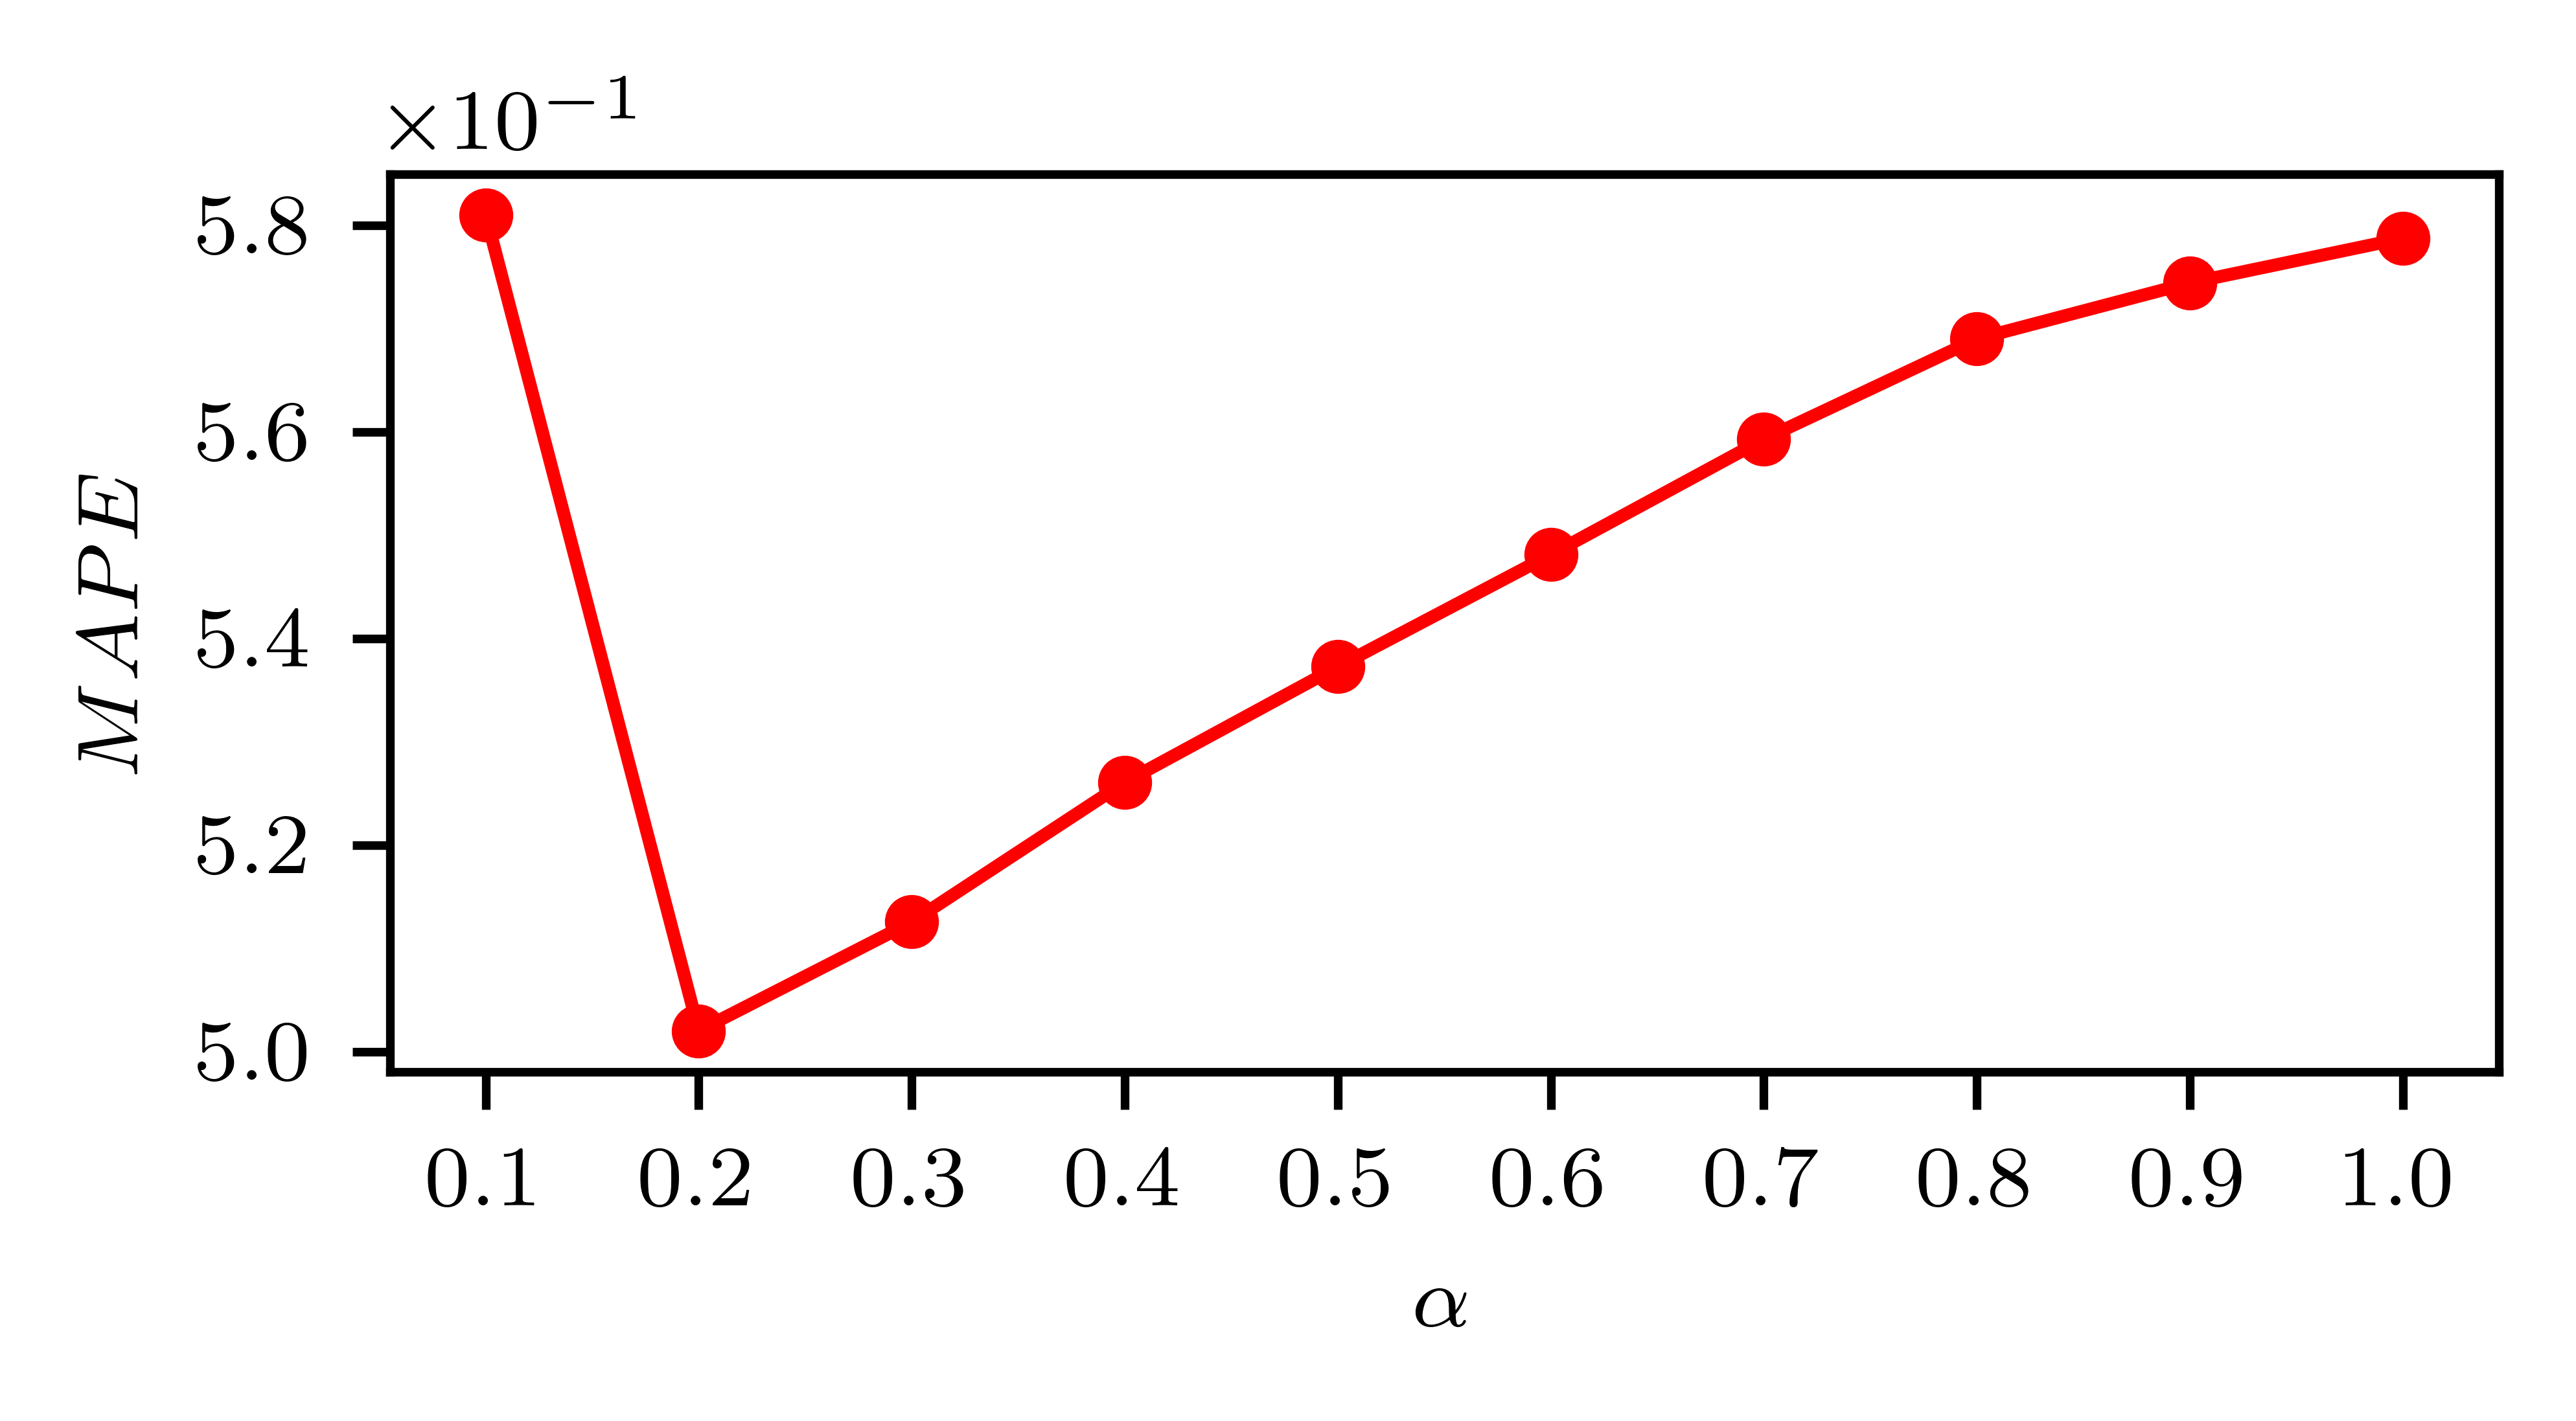

In [61]:
plt.figure(figsize=(3.5,1.5),dpi=1200)   #figsize=(3.5,1.5)

plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],MAPE_s[::-1],'o-',c='r',label=r'RMSE')

# plt.text(0.1, 0.186480, f'0.1854', ha='center')
# plt.text(0.2, 0.186480, f'0.1854', ha='center')
# plt.text(0.3, 0.185683, f'0.1896', ha='center')
# plt.text(0.4, 0.182793, f'0.1807', ha='center')
# plt.text(0.5, 0.183397, f'0.1823', ha='center')
# plt.text(0.6, 0.186480, f'0.1854', ha='center')
# plt.text(0.7, 0.185683, f'0.1896', ha='center')
# plt.text(0.8, 0.182793, f'0.1807', ha='center')
# plt.text(0.9, 0.183397, f'0.1823', ha='center')
# plt.text(1.0, 0.186480, f'0.1854', ha='center')

# plt.xlim(0.09, 1.01)
plt.xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.ticklabel_format(axis='both', style='sci', scilimits=(2, 6))
plt.ylabel('$MAPE$')
plt.xlabel(r'$\alpha$')
# plt.legend()
plt.savefig(root+'/picture/fig6/Fig6'+'_'+'MAPE_'+str(stock)+'.svg',bbox_inches='tight',format='svg')
plt.savefig(root+'/picture/fig6/Fig6'+'_'+'MAPE_'+str(stock)+'.pdf',bbox_inches='tight',format='pdf')
plt.show()